In [1]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, Conv3D, GlobalMaxPooling2D
from keras.initializers import glorot_uniform
import keras.backend as K
from keras.models import Model, load_model
from tensorflow.keras import layers
from keras.layers import Input

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table
from astropy.io import fits
from PIL import Image
from numba import cuda

In [3]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import scikitplot as skplt
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import fbeta_score

In [4]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [5]:
import sys
sys.path.append('..')
%load_ext autoreload
%autoreload 2
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [6]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


## Data

In [7]:
from astropy.table import Table

# Loads the table created in the previous section
data = Table.read(r'.....\GroundBasedTraining_Catalogs.hdf5')     

### Data Preprocessing

In [8]:
# We use the full set for training,
# as we can test on the independent challenge testing set
X = np.array(data['image'][:17000]).reshape((-1,101,101,4))
Y = np.array(data['is_lens'][:17000:]).reshape((-1,1))
X_Val = np.array(data['image'][17000:18000]).reshape((-1,101,101,4))
Y_Val = np.array(data['is_lens'][17000:18000]).reshape((-1,1))
X_test = np.array(data['image'][18000:]).reshape((-1,101,101,4))
Y_test = np.array(data['is_lens'][18000:]).reshape((-1,1))

In [9]:
# Clipping and scaling parameters applied to the data as preprocessing
vmin=-1e-9
vmax=1e-9
scale=100

mask = np.where(X == 100)
mask_val = np.where(X_Val ==100)
mask_test = np.where(X_test == 100)

X[mask] = 0
X_Val[mask_val] = 0
X_test[mask_test] = 0

# Simple clipping and rescaling the images
X = np.clip(X, vmin, vmax)/vmax * scale
X_Val = np.clip(X_Val, vmin, vmax)/vmax * scale
X_test = np.clip(X_test, vmin, vmax)/vmax * scale 

X[mask] = 0
X_Val[mask_val] = 0
X_test[mask_test] = 0

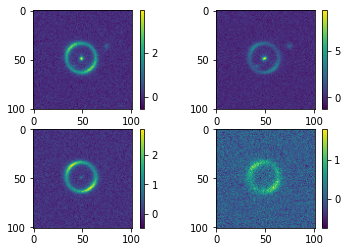

In [10]:
# Illustration of a lens in the 4 bands provided
im = X[0]
subplot(221)
imshow(im[:,:,0]); colorbar()
subplot(222)
imshow(im[:,:,1]); colorbar()
subplot(223) 
imshow(im[:,:,2]); colorbar()
subplot(224)
imshow(im[:,:,3]); colorbar()
plt.show()

In [11]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(width_shift_range=(-0.05,0.05),height_shift_range=(-0.05,0.05),horizontal_flip=True,vertical_flip=True)
datagen.fit(X)
datagen.fit(X_Val)

In [12]:
# pos in the formula denotes each feature or the columns of the processed input
# d represent the diamension of the of the each feature or namely the rows of the input x

def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(12800, (2 * (i//2)) / np.float64(d_model))
    return pos * angle_rates

def positional_encoding(position, d_model):
    angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)

  # apply sin to even indices in the array; 2i
    angle_rads[0::2,:] = np.sin(angle_rads[0::2,:])

  # apply cos to odd indices in the array; 2i+1
    angle_rads[1::2,:] = np.cos(angle_rads[1::2,:])

    pos_encoding = angle_rads[np.newaxis]

    return tf.cast(pos_encoding, dtype=tf.float64)    

### Lens Detector 

In [13]:
d_model = 128
maximum_position_encoding = 10000

scaling_factor = tf.keras.backend.constant(np.sqrt(d_model), shape = (1,1,1))

# Encoder ##################################
input_shape = (101,101,4)

inputs=Input(shape=(input_shape),name='input_layer')

x = Conv2D(filters=16, kernel_size=(4, 4), strides=(1, 1), padding='valid',activation='elu', kernel_initializer=glorot_uniform(seed=0),kernel_regularizer=tf.keras.regularizers.l2(0.01), name='Conv1' )(inputs)
x = BatchNormalization(axis=3)(x)
x = Conv2D(filters=16, kernel_size=(3, 3), strides=(1, 1), padding='valid',activation='elu', kernel_initializer=glorot_uniform(seed=0),kernel_regularizer=tf.keras.regularizers.l2(0.01), name='Conv2' )(x)
x = MaxPooling2D((2, 2),name='max1')(x)
x = BatchNormalization(axis=3)(x)

x = Conv2D(filters=32, kernel_size=(3, 3), strides=(1, 1), padding='valid',activation='elu', kernel_initializer=glorot_uniform(seed=0),kernel_regularizer=tf.keras.regularizers.l2(0.01),name='Conv3')(x)
x = BatchNormalization(axis=3)(x)
x = Conv2D(filters=32, kernel_size=(3, 3), strides=(1, 1), padding='valid',activation='elu', kernel_initializer=glorot_uniform(seed=0),kernel_regularizer=tf.keras.regularizers.l2(0.01),name='Conv4')(x)
x = MaxPooling2D((2, 2),name='max2')(x)
x = BatchNormalization(axis=3)(x)

x = Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding='valid',activation='elu', kernel_initializer=glorot_uniform(seed=0),kernel_regularizer=tf.keras.regularizers.l2(0.01),name='Conv5')(x)
x = BatchNormalization(axis=3)(x)
x = Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding='valid',activation='elu', kernel_initializer=glorot_uniform(seed=0),kernel_regularizer=tf.keras.regularizers.l2(0.01),name='Conv6')(x)
x = MaxPooling2D((2, 2),name='max3')(x)
x = BatchNormalization(axis=3)(x)
x = layers.Dropout(0.5)(x)

x = Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), padding='valid',activation='elu', kernel_initializer=glorot_uniform(seed=0),kernel_regularizer=tf.keras.regularizers.l2(0.01),name='Conv7')(x)
x = BatchNormalization(axis=3)(x)
x = layers.Dropout(0.5)(x)
x = Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), padding='valid',activation='elu', kernel_initializer=glorot_uniform(seed=0),kernel_regularizer=tf.keras.regularizers.l2(0.01),name='Conv8')(x)
x = BatchNormalization(axis=3)(x)
x = layers.Dropout(0.5)(x)

x= tf.reshape(tensor=x, shape=(tf.shape(x)[0], tf.shape(x)[1]*tf.shape(x)[2],d_model))

## positional encoding
x = tf.keras.layers.Multiply()([x,scaling_factor])
pos = positional_encoding(maximum_position_encoding, d_model)
x = tf.keras.layers.Add()([x, pos[: , :tf.shape(x)[1], :]] )

## Multihead Attention 1

x1 = tf.keras.layers.MultiHeadAttention(num_heads=8, key_dim=d_model, value_dim=d_model, dropout=0.20, use_bias=True, kernel_initializer='glorot_uniform', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x,x)
x2 = tf.keras.layers.MultiHeadAttention(num_heads=8, key_dim=d_model, value_dim=d_model, dropout=0.20, use_bias=True, kernel_initializer='glorot_uniform', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x,x)

x = tf.keras.layers.Add()([x1, x2]) 

x3 = tf.keras.layers.MultiHeadAttention(num_heads=8, key_dim=d_model, value_dim=d_model, dropout=0.20, use_bias=True, kernel_initializer='glorot_uniform', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x,x)
x4 = tf.keras.layers.MultiHeadAttention(num_heads=8, key_dim=d_model, value_dim=d_model, dropout=0.20, use_bias=True, kernel_initializer='glorot_uniform', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x,x)

x = tf.keras.layers.Add()([x3, x4]) 

## Feed Forward 1
dense =  Dense(2*d_model, activation = 'elu',kernel_initializer="glorot_uniform",name='dense1')(x)
dense = layers.Dropout(0.5)(dense)
dense =  Dense(d_model, activation = 'elu',kernel_initializer="glorot_uniform",name='dense2')(dense)
dense = layers.Dropout(0.5)(dense)
x = tf.keras.layers.Add()([x , dense])                                          # residual connection
x = tf.keras.layers.LayerNormalization(epsilon=1e-6)(x)

######################################################

x = tf.keras.layers.GlobalAveragePooling1D()(x)

######################################################


x =  Dense(1024, activation = 'elu',kernel_initializer="glorot_uniform",name='dense4')(x)
x = layers.Dropout(0.5)(x)

x =  Dense(512, activation = 'elu',kernel_initializer="glorot_uniform",name='dense5')(x)
x = layers.Dropout(0.5)(x)

x =  Dense(128, activation = 'elu',kernel_initializer="glorot_uniform",name='dense6')(x)
x = layers.Dropout(0.5)(x)


In [14]:
output = layers.Dense(1, activation="sigmoid")(x)

Lens_Detector = tf.keras.models.Model(inputs=inputs, outputs=output)


In [15]:
lr_schedule1 = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=1e-4,decay_steps=10000,decay_rate=0.9)
opt1=tf.keras.optimizers.Adam(learning_rate=lr_schedule1, beta_1=0.9, beta_2=0.999, epsilon=1e-07)

Lens_Detector.compile(optimizer=opt1, loss='binary_crossentropy', metrics=['accuracy',tf.keras.metrics.AUC()])

In [16]:
Lens_Detector.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_layer (InputLayer)        [(None, 101, 101, 4) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 98, 98, 16)   1040        input_layer[0][0]                
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 98, 98, 16)   64          Conv1[0][0]                      
__________________________________________________________________________________________________
Conv2 (Conv2D)                  (None, 96, 96, 16)   2320        batch_normalization[0][0]        
______________________________________________________________________________________________

In [20]:
Lens_Detector_history = Lens_Detector.fit(datagen.flow(X,Y),epochs=300,validation_data=datagen.flow(X_Val,Y_Val),batch_size=128,verbose=1) #Training the network with 10% of training

Epoch 1/300
532/532 [==============================] - 55s 86ms/step - loss: 10.4370 - accuracy: 0.6682 - auc: 0.7035 - val_loss: 7.1658 - val_accuracy: 0.7680 - val_auc: 0.8554
Epoch 2/300
532/532 [==============================] - 46s 85ms/step - loss: 6.3717 - accuracy: 0.7561 - auc: 0.8156 - val_loss: 4.3701 - val_accuracy: 0.7900 - val_auc: 0.8794
Epoch 3/300
532/532 [==============================] - 45s 85ms/step - loss: 3.9391 - accuracy: 0.7740 - auc: 0.8398 - val_loss: 2.9770 - val_accuracy: 0.8090 - val_auc: 0.8831
Epoch 4/300
532/532 [==============================] - 45s 84ms/step - loss: 2.6407 - accuracy: 0.8023 - auc: 0.8727 - val_loss: 2.0860 - val_accuracy: 0.8260 - val_auc: 0.9110
Epoch 5/300
532/532 [==============================] - 44s 83ms/step - loss: 1.9741 - accuracy: 0.8165 - auc: 0.8810 - val_loss: 1.6539 - val_accuracy: 0.8350 - val_auc: 0.9245
Epoch 6/300
532/532 [==============================] - 45s 84ms/step - loss: 1.5815 - accuracy: 0.8340 - auc: 0.89

532/532 [==============================] - 45s 85ms/step - loss: 0.3566 - accuracy: 0.9187 - auc: 0.9725 - val_loss: 0.3119 - val_accuracy: 0.9300 - val_auc: 0.9851
Epoch 48/300
532/532 [==============================] - 45s 85ms/step - loss: 0.3391 - accuracy: 0.9220 - auc: 0.9772 - val_loss: 0.3913 - val_accuracy: 0.9290 - val_auc: 0.9730
Epoch 49/300
532/532 [==============================] - 45s 85ms/step - loss: 0.3475 - accuracy: 0.9196 - auc: 0.9737 - val_loss: 0.3318 - val_accuracy: 0.9330 - val_auc: 0.9802
Epoch 50/300
532/532 [==============================] - 45s 84ms/step - loss: 0.3334 - accuracy: 0.9266 - auc: 0.9762 - val_loss: 0.3770 - val_accuracy: 0.9260 - val_auc: 0.9728
Epoch 51/300
532/532 [==============================] - 46s 86ms/step - loss: 0.3348 - accuracy: 0.9219 - auc: 0.9762 - val_loss: 0.3474 - val_accuracy: 0.9370 - val_auc: 0.9756
Epoch 52/300
532/532 [==============================] - 45s 85ms/step - loss: 0.3500 - accuracy: 0.9217 - auc: 0.9739 - val

Epoch 139/300
532/532 [==============================] - 45s 84ms/step - loss: 0.2243 - accuracy: 0.9435 - auc: 0.9858 - val_loss: 0.2632 - val_accuracy: 0.9450 - val_auc: 0.9812
Epoch 140/300
532/532 [==============================] - 45s 85ms/step - loss: 0.2245 - accuracy: 0.9433 - auc: 0.9856 - val_loss: 0.3212 - val_accuracy: 0.9180 - val_auc: 0.9801
Epoch 141/300
532/532 [==============================] - 45s 84ms/step - loss: 0.2345 - accuracy: 0.9374 - auc: 0.9839 - val_loss: 0.2548 - val_accuracy: 0.9470 - val_auc: 0.9841
Epoch 142/300
532/532 [==============================] - 46s 86ms/step - loss: 0.2235 - accuracy: 0.9436 - auc: 0.9856 - val_loss: 0.2355 - val_accuracy: 0.9460 - val_auc: 0.9854
Epoch 143/300
532/532 [==============================] - 44s 83ms/step - loss: 0.2147 - accuracy: 0.9469 - auc: 0.9877 - val_loss: 0.2527 - val_accuracy: 0.9430 - val_auc: 0.9823
Epoch 144/300
532/532 [==============================] - 45s 85ms/step - loss: 0.2284 - accuracy: 0.9407 

Epoch 185/300
532/532 [==============================] - 45s 84ms/step - loss: 0.2001 - accuracy: 0.9495 - auc: 0.9885 - val_loss: 0.2551 - val_accuracy: 0.9340 - val_auc: 0.9820
Epoch 186/300
532/532 [==============================] - 45s 84ms/step - loss: 0.2010 - accuracy: 0.9472 - auc: 0.9879 - val_loss: 0.2293 - val_accuracy: 0.9500 - val_auc: 0.9849
Epoch 187/300
532/532 [==============================] - 45s 84ms/step - loss: 0.1981 - accuracy: 0.9503 - auc: 0.9890 - val_loss: 0.2683 - val_accuracy: 0.9450 - val_auc: 0.9793
Epoch 188/300
532/532 [==============================] - 45s 85ms/step - loss: 0.2053 - accuracy: 0.9463 - auc: 0.9877 - val_loss: 0.4145 - val_accuracy: 0.9230 - val_auc: 0.9596
Epoch 189/300
532/532 [==============================] - 45s 85ms/step - loss: 0.1892 - accuracy: 0.9535 - auc: 0.9895 - val_loss: 0.2598 - val_accuracy: 0.9410 - val_auc: 0.9784
Epoch 190/300
532/532 [==============================] - 45s 85ms/step - loss: 0.1990 - accuracy: 0.9474 

Epoch 276/300
532/532 [==============================] - 45s 85ms/step - loss: 0.1682 - accuracy: 0.9573 - auc: 0.9916 - val_loss: 0.2373 - val_accuracy: 0.9500 - val_auc: 0.9824
Epoch 277/300
532/532 [==============================] - 45s 85ms/step - loss: 0.1661 - accuracy: 0.9585 - auc: 0.9916 - val_loss: 0.2299 - val_accuracy: 0.9440 - val_auc: 0.9843
Epoch 278/300
532/532 [==============================] - 45s 84ms/step - loss: 0.1633 - accuracy: 0.9582 - auc: 0.9920 - val_loss: 0.2502 - val_accuracy: 0.9410 - val_auc: 0.9808
Epoch 279/300
532/532 [==============================] - 45s 85ms/step - loss: 0.1664 - accuracy: 0.9562 - auc: 0.9917 - val_loss: 0.2738 - val_accuracy: 0.9470 - val_auc: 0.9744
Epoch 280/300
532/532 [==============================] - 45s 84ms/step - loss: 0.1654 - accuracy: 0.9588 - auc: 0.9914 - val_loss: 0.2478 - val_accuracy: 0.9500 - val_auc: 0.9814
Epoch 281/300
532/532 [==============================] - 45s 85ms/step - loss: 0.1667 - accuracy: 0.9564 

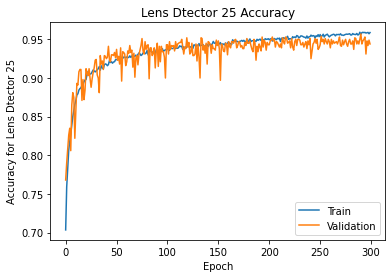

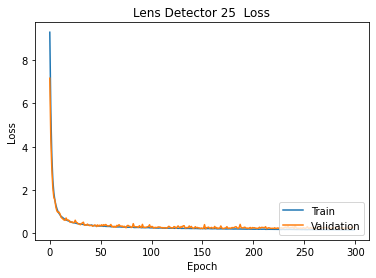

In [21]:
plt.plot(Lens_Detector_history.history['accuracy'])
plt.plot(Lens_Detector_history.history['val_accuracy'])
plt.title('Lens Dtector 25 Accuracy')
plt.ylabel('Accuracy for Lens Dtector 25')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()
# summarize history for loss
plt.plot(Lens_Detector_history.history['loss'])
plt.plot(Lens_Detector_history.history['val_loss'])
plt.title('Lens Detector 25  Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

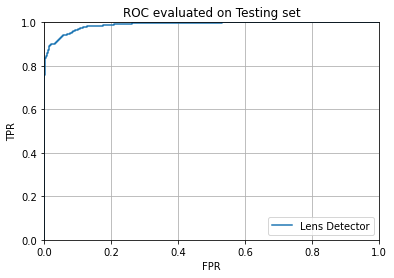

The area under the ROC curve is  0.9886697940273422
16/16 [==============================] - 3s 71ms/step - loss: 0.2372 - accuracy: 0.9450 - auc: 0.9858


[0.25765272974967957, 0.9455000162124634, 0.9815954566001892]

In [18]:
X_test_pred =Lens_Detector.predict(X_test)

frp_transformer,tpr_transformer,thr_transformer = roc_curve(Y_test,X_test_pred)

plt.plot(frp_transformer,tpr_transformer,label='Lens Detector')
xlim(0,1)
ylim(0,1)
legend(loc=4)
xlabel('FPR')
ylabel('TPR')
title('ROC evaluated on Testing set')
grid('on') 
plt.show()

print('The area under the ROC curve is ',roc_auc_score(Y_test,X_test_pred))
Lens_Detector.evaluate(X_test,Y_test,batch_size=128,verbose=1)

In [23]:
k=1
for i in range(len(frp_transformer)):
    if frp_transformer25[i] !=0:
        print(i)
        k=i
        break 

print('The TPR0 is ',tpr_transformer[k-1])
print('The TPR10 is ',tpr_transformer[k +7])
print (thr_transformer25[k-1])

58
The TPR0 is  0.7084870848708487
The TPR10 is  0.8216482164821648
0.9998598


In [43]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=1e-5,decay_steps=1000,decay_rate=0.9)
opt=tf.keras.optimizers.Adam(learning_rate=lr_schedule, beta_1=0.9, beta_2=0.999, epsilon=1e-07)

Lens_Detector.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy',tf.keras.metrics.AUC()])

In [44]:
Lens_Detector_history = Lens_Detector.fit(datagen.flow(X,Y),epochs=100,validation_data=datagen.flow(X_Val,Y_Val),batch_size=128,verbose=1) #Training the network with 10% of training

Epoch 1/100
532/532 [==============================] - 79s 97ms/step - loss: 0.1547 - accuracy: 0.9622 - auc_1: 0.9927 - val_loss: 0.2630 - val_accuracy: 0.9400 - val_auc_1: 0.9758
Epoch 2/100
532/532 [==============================] - 47s 87ms/step - loss: 0.1606 - accuracy: 0.9591 - auc_1: 0.9922 - val_loss: 0.2586 - val_accuracy: 0.9460 - val_auc_1: 0.9802
Epoch 3/100
532/532 [==============================] - 46s 86ms/step - loss: 0.1518 - accuracy: 0.9611 - auc_1: 0.9938 - val_loss: 0.2578 - val_accuracy: 0.9500 - val_auc_1: 0.9758
Epoch 4/100
532/532 [==============================] - 46s 85ms/step - loss: 0.1524 - accuracy: 0.9644 - auc_1: 0.9933 - val_loss: 0.2161 - val_accuracy: 0.9480 - val_auc_1: 0.9827
Epoch 5/100
532/532 [==============================] - 47s 87ms/step - loss: 0.1487 - accuracy: 0.9621 - auc_1: 0.9939 - val_loss: 0.2635 - val_accuracy: 0.9450 - val_auc_1: 0.9775
Epoch 6/100
532/532 [==============================] - 49s 92ms/step - loss: 0.1506 - accuracy:

532/532 [==============================] - 44s 83ms/step - loss: 0.1385 - accuracy: 0.9657 - auc_1: 0.9944 - val_loss: 0.2539 - val_accuracy: 0.9500 - val_auc_1: 0.9792
Epoch 47/100
532/532 [==============================] - 45s 85ms/step - loss: 0.1370 - accuracy: 0.9652 - auc_1: 0.9946 - val_loss: 0.2506 - val_accuracy: 0.9510 - val_auc_1: 0.9814
Epoch 48/100
532/532 [==============================] - 45s 84ms/step - loss: 0.1390 - accuracy: 0.9661 - auc_1: 0.9943 - val_loss: 0.2610 - val_accuracy: 0.9440 - val_auc_1: 0.9796
Epoch 49/100
532/532 [==============================] - 45s 84ms/step - loss: 0.1423 - accuracy: 0.9643 - auc_1: 0.9941 - val_loss: 0.2696 - val_accuracy: 0.9460 - val_auc_1: 0.9767
Epoch 50/100
532/532 [==============================] - 45s 85ms/step - loss: 0.1349 - accuracy: 0.9688 - auc_1: 0.9953 - val_loss: 0.2573 - val_accuracy: 0.9490 - val_auc_1: 0.9798
Epoch 51/100
532/532 [==============================] - 45s 84ms/step - loss: 0.1387 - accuracy: 0.9676

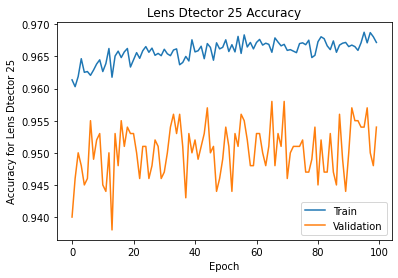

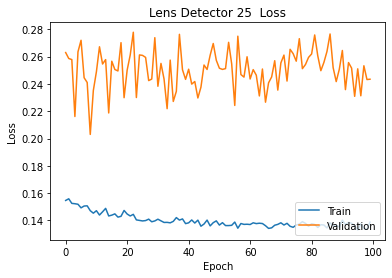

In [47]:
plt.plot(Lens_Detector_history.history['accuracy'])
plt.plot(Lens_Detector_history.history['val_accuracy'])
plt.title('Lens Dtector 25 Accuracy')
plt.ylabel('Accuracy for Lens Dtector 25')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()
# summarize history for loss
plt.plot(Lens_Detector_history.history['loss'])
plt.plot(Lens_Detector_history.history['val_loss'])
plt.title('Lens Detector 25  Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()


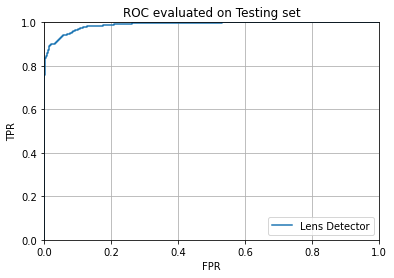

The area under the ROC curve is  0.9886697940273422
16/16 [==============================] - 1s 47ms/step - loss: 0.2577 - accuracy: 0.9455 - auc: 0.9816


[0.25765272974967957, 0.9455000162124634, 0.9815954566001892]

In [45]:
X_test_pred =Lens_Detector.predict(X_test)

frp_transformer2,tpr_transformer2,thr_transformer2 = roc_curve(Y_test,X_test_pred)

plt.plot(frp_transformer2,tpr_transformer2,label='Lens Detector')
xlim(0,1)
ylim(0,1)
legend(loc=4)
xlabel('FPR')
ylabel('TPR')
title('ROC evaluated on Testing set')
grid('on') 
plt.show()

print('The area under the ROC curve is ',roc_auc_score(Y_test,X_test_pred))
Lens_Detector.evaluate(X_test,Y_test,batch_size=128,verbose=1)

In [44]:
1+1

2

In [46]:
k=1
for i in range(len(frp_transformer2)):
    if frp_transformer2[i] !=0:
        print(i)
        k=i
        break 

print('The TPR0 is ',tpr_transformer2[k-1])
print('The TPR10 is ',tpr_transformer2[k +7])
print (thr_transformer2[k-1])

58
The TPR0 is  0.7084870848708487
The TPR10 is  0.8216482164821648
0.9998598


In [48]:
Lens_Detector.save(r'......\Lens Detector',save_format='h5')

# Testing the Trained Models

### Test on the Dataset 3

For the Challange there was 5 test sets available. The above results was for Test Set 1. For Set 3 we have created 10 batch with 10000 images in each batch file.

### Batch 1 - 10

In [50]:
Y_predicted_25 = []
Y_Correct = []
vmin=-1e-9
vmax=1e-9
scale=100

In [51]:
start = time.time()
for i in range (1,11):
    data3 = Table.read(r'..........\GroundBasedTest_Catalog'+str(i)+'.hdf5')
    X3 = np.array(data3['image'][:10000]).reshape((-1,101,101,4))
    Y3 = np.array(data3['no_source'][:10000:]).reshape((-1,1))
    Y3 = np.logical_not(Y3).astype(int) 

# Clipping and scaling parameters applied to the data as preprocessing
 
    mask = np.where(X3 == 100)
    X3[mask] = 0                                      
    X3 = np.clip(X3, vmin, vmax)/vmax * scale
    X3[mask] = 0
    
    X3_pred25 = Lens_Detector.predict(X3)
    Y_predicted_25.append(X3_pred25)

    Y_Correct.append(Y3)
    print("The time taken to test ",i,"0000 data samples is ",time.time()-start,"seconds")
    print(i)

The time taken to test  1 0000 data samples is  148.7931628227234 seconds
1
The time taken to test  2 0000 data samples is  274.47501254081726 seconds
2
The time taken to test  3 0000 data samples is  394.4102132320404 seconds
3
The time taken to test  4 0000 data samples is  503.29219937324524 seconds
4
The time taken to test  5 0000 data samples is  597.941513299942 seconds
5
The time taken to test  6 0000 data samples is  705.1247825622559 seconds
6
The time taken to test  7 0000 data samples is  825.9296126365662 seconds
7
The time taken to test  8 0000 data samples is  951.9333419799805 seconds
8
The time taken to test  9 0000 data samples is  1136.259574174881 seconds
9
The time taken to test  10 0000 data samples is  1268.1402258872986 seconds
10


In [52]:
Testset3_Y_Predicted = np.reshape(Y_predicted_25,(100000,1))

In [58]:
Testset3_Y_Correct = np.reshape(Y_predicted_25,(100000,1))

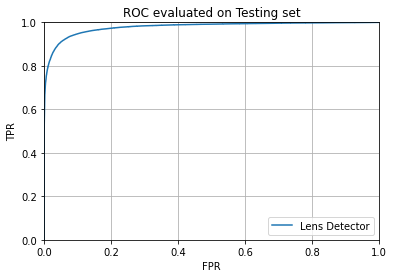

The area under the ROC curve is  0.9783548241461755


In [61]:
False_P_rate2,True_P_rate2,threshold2 = roc_curve(Testset3_Y_Correct,Testset3_Y_Predicted,pos_label=1)

plt.plot(False_P_rate2,True_P_rate2,label='Lens Detector')
xlim(0,1)
ylim(0,1)
legend(loc=4)
xlabel('FPR')
ylabel('TPR')
title('ROC evaluated on Testing set')
grid('on')
plt.show()
print('The area under the ROC curve is ',roc_auc_score(Testset3_Y_Correct,Testset3_Y_Predicted))

In [62]:
for i in range(len(False_P_rate2)):
    if False_P_rate2[i] !=0:
        K=i
        break 
        
print('The TPR0 is ',True_P_rate2[K-1])
print('The TPR10 is ',True_P_rate2[K +7])

The TPR0 is  0.14006144270667092
The TPR10 is  0.4827242259814874


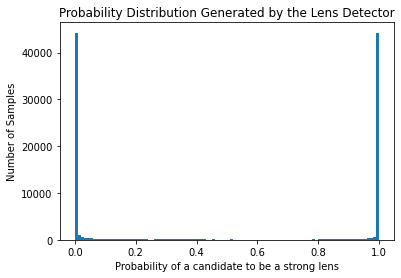

In [63]:
plt.hist(Testset3_Y_Predicted, bins = 100) 
plt.title("Probability Distribution Generated by the Lens Detector") 
xlabel('Probability of a candidate to be a strong lens')
ylabel('Number of Samples')
plt.show()

In [64]:
Transformer_Result=[]
for i in range(0,len(Testset3_Y_Predicted)):
    if Testset3_Y_Predicted[i]>0.5:
        y=1
    if Testset3_Y_Predicted[i]<0.5:
        y=0
    Transformer_Result.append(y)

The Accuracy of the model is  0.92998
              precision    recall  f1-score   support

         0.0       0.92      0.94      0.93     49872
         1.0       0.94      0.92      0.93     50128

    accuracy                           0.93    100000
   macro avg       0.93      0.93      0.93    100000
weighted avg       0.93      0.93      0.93    100000

[[46952  2920]
 [ 4082 46046]]
The fbeta_score is  0.9301904459950419


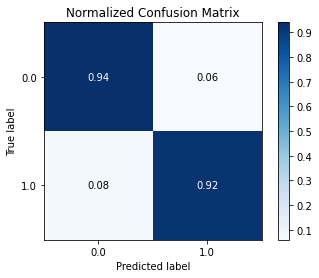

In [65]:
print("The Accuracy of the model is ", accuracy_score(Testset3_Y_Correct,Transformer_Result))

print(classification_report(Testset3_Y_Correct,Transformer_Result))

print(confusion_matrix(Testset3_Y_Correct,Transformer_Result))
print('The fbeta_score is ', fbeta_score(Testset3_Y_Correct,Transformer_Result, average='macro', beta=0.001))
skplt.metrics.plot_confusion_matrix(Testset3_Y_Correct,Transformer_Result, normalize=True)
plt.show()

In [66]:
Transformer_Result1=[]
for i in range(0,len(Testset3_Y_Predicted)):
    if Testset3_Y_Predicted[i]>0.9:
        y=1
    if Testset3_Y_Predicted[i]<0.9:
        y=0
    Transformer_Result1.append(y)

The Accuracy of the model is  0.92536
              precision    recall  f1-score   support

         0.0       0.90      0.96      0.93     49872
         1.0       0.96      0.89      0.92     50128

    accuracy                           0.93    100000
   macro avg       0.93      0.93      0.93    100000
weighted avg       0.93      0.93      0.93    100000

[[47972  1900]
 [ 5564 44564]]
The fbeta_score is  0.9275890233332255


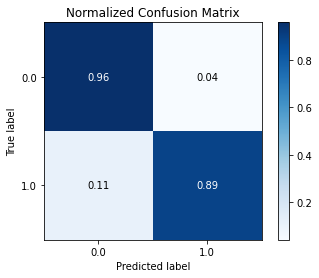

In [67]:
print("The Accuracy of the model is ", accuracy_score(Testset3_Y_Correct,Transformer_Result1))

print(classification_report(Testset3_Y_Correct,Transformer_Result1))

print(confusion_matrix(Testset3_Y_Correct,Transformer_Result1))
print('The fbeta_score is ', fbeta_score(Testset3_Y_Correct,Transformer_Result1, average='macro', beta=0.001))
skplt.metrics.plot_confusion_matrix(Testset3_Y_Correct,Transformer_Result1, normalize=True)
plt.show()

In [68]:
Transformer_Result2=[]
for i in range(0,len(Testset3_Y_Predicted)):
    if Testset3_Y_Predicted[i]>0.99:
        y=1
    if Testset3_Y_Predicted[i]<0.99:
        y=0
    Transformer_Result2.append(y)

The Accuracy of the model is  0.91599
              precision    recall  f1-score   support

         0.0       0.87      0.97      0.92     49872
         1.0       0.97      0.86      0.91     50128

    accuracy                           0.92    100000
   macro avg       0.92      0.92      0.92    100000
weighted avg       0.92      0.92      0.92    100000

[[48608  1264]
 [ 7137 42991]]
The fbeta_score is  0.9217043994169771


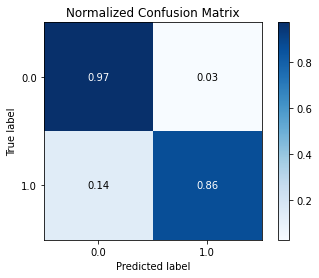

In [69]:
print("The Accuracy of the model is ", accuracy_score(Testset3_Y_Correct,Transformer_Result2))

print(classification_report(Testset3_Y_Correct,Transformer_Result2))

print(confusion_matrix(Testset3_Y_Correct,Transformer_Result2))
print('The fbeta_score is ', fbeta_score(Testset3_Y_Correct,Transformer_Result2, average='macro', beta=0.001))
skplt.metrics.plot_confusion_matrix(Testset3_Y_Correct,Transformer_Result2, normalize=True)
plt.show()

In [72]:
Transformer_Result3=[]
for i in range(0,len(Testset3_Y_Predicted)):
    if Testset3_Y_Predicted[i]>0.999:
        y=1
    if Testset3_Y_Predicted[i]<0.999:
        y=0
    Transformer_Result3.append(y)

The Accuracy of the model is  0.9004
              precision    recall  f1-score   support

         0.0       0.84      0.98      0.91     49872
         1.0       0.98      0.82      0.89     50128

    accuracy                           0.90    100000
   macro avg       0.91      0.90      0.90    100000
weighted avg       0.91      0.90      0.90    100000

[[49105   767]
 [ 9193 40935]]
The fbeta_score is  0.9119588597421142


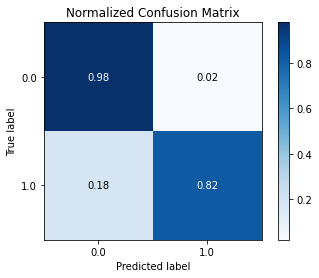

In [73]:
print("The Accuracy of the model is ", accuracy_score(Testset3_Y_Correct,Transformer_Result3))

print(classification_report(Testset3_Y_Correct,Transformer_Result3))

print(confusion_matrix(Testset3_Y_Correct,Transformer_Result3))
print('The fbeta_score is ', fbeta_score(Testset3_Y_Correct,Transformer_Result3, average='macro', beta=0.001))
skplt.metrics.plot_confusion_matrix(Testset3_Y_Correct,Transformer_Result3, normalize=True)
plt.show()

In [75]:
device = cuda.get_current_device()
device.reset()